In [20]:
using DataFrames
using Gadfly
using Cairo
using MIToS.PDB
using Compose
using Distributions
using HypothesisTests
set_default_plot_size(40cm, 14cm)

In [21]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [22]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [23]:
function read_ptraj_modes(file, modes_elements, nmodes::Int64=0, norma::Bool=true)    

    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    comments=true, comment_char='\*')
    close(modes_file)

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 3 methods)

In [24]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [25]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [26]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
prt_name = "1hvr_apo"
avg_1_filename = string("/home/german/labo/16/rtas_a_reviewers/ndd_check/bu/1avg_", prt_name, ".pdb")
avg_2_filename = string("/home/german/labo/16/rtas_a_reviewers/ndd_check/bu/2avg_", prt_name, ".pdb")
avg_1_pdb = read(avg_1_filename, PDBFile, group="ATOM");
avg_2_pdb = read(avg_2_filename, PDBFile, group="ATOM");

# Obtengo el número de átomos de c/ residuo
for i=1:length(avg_1_pdb)
    push!(natom_res, length(avg_1_pdb[i]))
end
shift!(natom_res)

# Obtengo el nro de aa's
aa = length(avg_1_pdb)
aa3 = aa * 3

# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn = Array{Float64}(aa3-6);
vol_ndd = Array{Float64, 2}(0, 2);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1_filename = string("/home/german/labo/16/rtas_a_reviewers/cvgcia/1hvr_apo/1modes_1hvr_apo")
modes_prt_1, evals_prt_1 = read_ptraj_modes(modes_1_filename, aa3);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/rtas_a_reviewers/ndd_check/"
# Archivos de config de ANA
conf_1_prt_whole = "/home/german/labo/16/rtas_a_reviewers/cvgcia/1cavities/bu/2_1hvr_apo.cfg"

"/home/german/labo/16/rtas_a_reviewers/cvgcia/1cavities/bu/2_1hvr_apo.cfg"

In [27]:
modo_sum = Array{Float64}(aa, 3);
factorr = Array{Float64}(aa3-6);
constant = 1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
j = 1
for magnitude in collect(-10:10)

    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
        for i=1:aa
            modo_sum[i, 1] = modes_prt_1[i*3-2, j]
            modo_sum[i, 2] = modes_prt_1[i*3-1, j]
            modo_sum[i, 3] = modes_prt_1[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1
                temp1_modo_sum = repmat(transpose(modo_sum[1, :]), natom_res[i])
                continue
            end
            temp2_modo_sum = repmat(transpose(modo_sum[i, :]), natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
        modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factorr[j] = magnitude * constant * 1/evals_prt_1[j]
# Modifico las coordenadas
        hvr_apo_atom_xyz = coordinatesmatrix(avg_1_pdb)
        new_hvr_apo_atom_xyz = hvr_apo_atom_xyz + modo_sum .* factorr[j];
# Obtengo un nuevo frame con las coordenadas modificadas
        new_pdb_pdb = change_coordinates(avg_1_pdb, new_hvr_apo_atom_xyz)
# Escribo el nuevo .pdb
        pdb_hvr_apo = string(files_template, "pdbs/", displacement, "mod", j, "_hvr_apo.pdb")
        write(pdb_hvr_apo, new_pdb_pdb, PDBFile)
end
avg_filename = string(files_template,"pdbs/", "d0mod", j, "_hvr_apo.pdb")

"/home/german/labo/16/rtas_a_reviewers/ndd_check/pdbs/d0mod1_hvr_apo.pdb"

## ANA MD

In [114]:
# Calculo el pocket avg  
in_cfg_filename = string(files_template, "ana/", "2_1hvr_apo.cfg")
avg_ana_vol = parse(Float64, readstring(`ANA $avg_filename -c $in_cfg_filename`)[10:end-2])

# Ahora, todos los .pdbs desplazados
vol_ana = Array{Float64, 1}(21)
delta_ana = Array{Float64, 1}(21)
gdt_ana = Array{Float64, 1}(21)
k = 0
for magnitude in collect(-10:10)
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        displacement = string("d_", abs(magnitude))
    end    
    j = 1
    k += 1
    # Preparo variables
    in_pdb_filename = string(files_template, "pdbs/", displacement, "mod", j, "_hvr_apo.pdb")
    out_vol_filename = string(files_template, "ana/", displacement, "mod", j, "_ana_vol")
    
    # Calculo el pocket           
    vol_ana[k] = parse(Float64, readstring(`ANA $in_pdb_filename -c $in_cfg_filename`)[10:end-2])
    delta_ana[k] = vol_ana[k] - avg_ana_vol
    gdt_ana[k] = delta_ana[k] / abs(magnitude)
end
vol_ana[isnan.(vol_ana)] = 0
delta_ana[isnan.(delta_ana)] = 0
gdt_ana[11] = 0

0

## ANA NDD

In [50]:
# Ahora, todos los .pdbs desplazados
ndd_input_filename = string(files_template, "ndd/in_ndd")
ndd_output_filename = string(files_template, "ndd/out_ndd")

# Calculo el pocket           
readstring(`ANA $avg_filename -c $in_cfg_filename -I $ndd_input_filename -O $ndd_output_filename`);

vol_ndd = readdlm(ndd_output_filename, header=true)[1][:, 2] 
delta_ndd = vol_ndd .- avg_ana_vol
gdt_ndd = delta_ndd ./ [ collect(10:-1:1) ; 1 ; collect(1:10) ];

## Epock

In [116]:
# Calculo el pocket avg  
    in_cfg_filename = string(files_template, "epock/", "epock.cfg")
    out_vol_filename = string(files_template, "epock/", "d0mod", j, "_epock_vol")
    run(`epock -s $avg_filename -c $in_cfg_filename -o $out_vol_filename`);
    # Leo
    avg_epock_vol = readdlm(out_vol_filename, header=true)[1][2]

# Ahora, todos los .pdbs desplazados
vol_epock = Array{Float64, 1}(21)
delta_epock = Array{Float64, 1}(21)
gdt_epock = Array{Float64, 1}(21)
k = 0
for magnitude in collect(-10:10)
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        displacement = string("d_", abs(magnitude))
    end 
    
    j = 1
    k += 1
    # Preparo variables
    in_pdb_filename = string(files_template, "pdbs/", displacement, "mod", j, "_hvr_apo.pdb")
    out_vol_filename = string(files_template, "epock/", displacement, "mod", j, "_epock_vol")
    
    # Calculo el pocket           
    run(`epock -s $in_pdb_filename -c $in_cfg_filename -o $out_vol_filename`);
    # Leo
    vol_epock[k] = readdlm(out_vol_filename, header=true)[1][2]
    delta_epock[k] = vol_epock[k] - avg_epock_vol
    gdt_epock[k] = (vol_epock[k] - avg_epock_vol) / abs(magnitude)
end
delta_epock[isnan.(delta_epock)] = 0
gdt_epock[11] = 0

0

## MDpocket

In [117]:
out_vol_filename = string(files_template, "mdpocket/mdpout_descriptors.txt")
vol_mdpoc = readdlm(out_vol_filename, header=true)[1][:, 2] 
delta_mdpoc = vol_mdpoc .- vol_mdpoc[11]
gdt_mdpoc =  delta_mdpoc ./ [ collect(10:-1:1) ; 1 ; collect(1:10) ];

# Plots

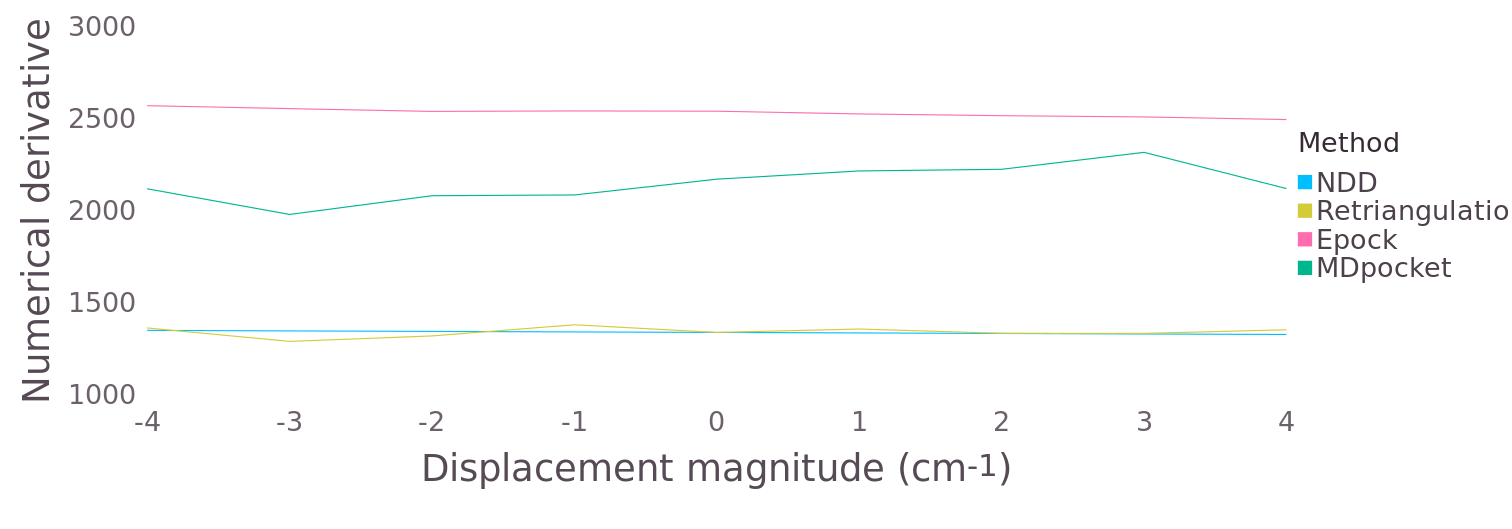

In [105]:
df_vol = DataFrame(Gradient = [ vol_ndd[7:15] ; vol_ana[7:15] ; vol_epock[7:15] ; vol_mdpoc[7:15] ],
    Displacement = repeat([ collect(-4:1:-1) ; 0 ; collect(1:4) ], outer = [4]),
    Method = repeat([ "NDD" ; "Retriangulation" ; "Epock" ; "MDpocket" ], inner = [9]))

plot_fig = plot(df_vol, Geom.line, x = "Displacement", y = "Gradient", color = "Method",

Guide.xlabel("Displacement magnitude (cm<sup>-1</sup>)"), 
Guide.xticks(ticks = [ collect(-4:1:-1) ; 0 ; collect(1:4) ]),
Guide.ylabel("Numerical derivative", orientation=:vertical),
#Guide.yticks(ticks = collect(0.1:0.1:.3)),
Theme(bar_spacing=2pt, grid_line_width=0pt,
minor_label_font_size = 20pt, major_label_font_size = 28pt, key_title_font_size = 20pt,
        key_label_font_size = 20pt))

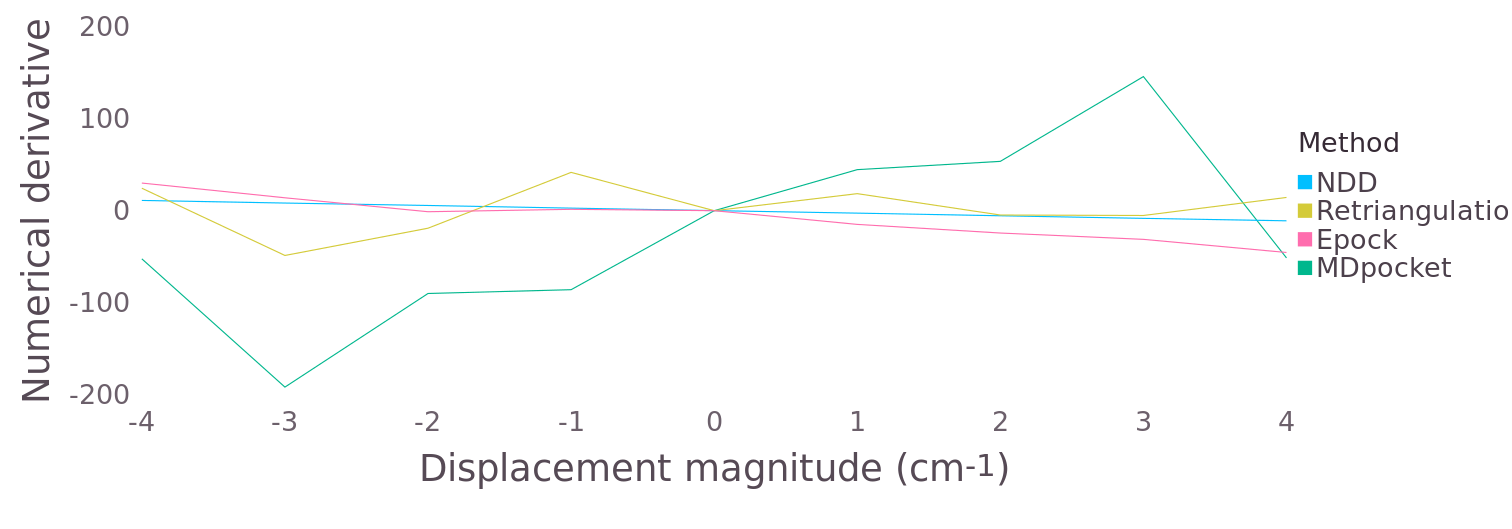

In [107]:
df_delta = DataFrame(Gradient = [ delta_ndd[7:15] ; delta_ana[7:15] ; delta_epock[7:15] ; delta_mdpoc[7:15] ],
    Displacement = repeat([ collect(-4:1:-1) ; 0 ; collect(1:4) ], outer = [4]),
    Method = repeat([ "NDD" ; "Retriangulation" ; "Epock" ; "MDpocket" ], inner = [9]))

plot_fig = plot(df_delta, Geom.line, x = "Displacement", y = "Gradient", color = "Method",

Guide.xlabel("Displacement magnitude (cm<sup>-1</sup>)"), 
Guide.xticks(ticks = [ collect(-4:1:-1) ; 0 ; collect(1:4) ]),
Guide.ylabel("Numerical derivative", orientation=:vertical),
#Guide.yticks(ticks = collect(0.1:0.1:.3)),
Theme(bar_spacing=2pt, grid_line_width=0pt,
minor_label_font_size = 20pt, major_label_font_size = 28pt, key_title_font_size = 20pt,
        key_label_font_size = 20pt))

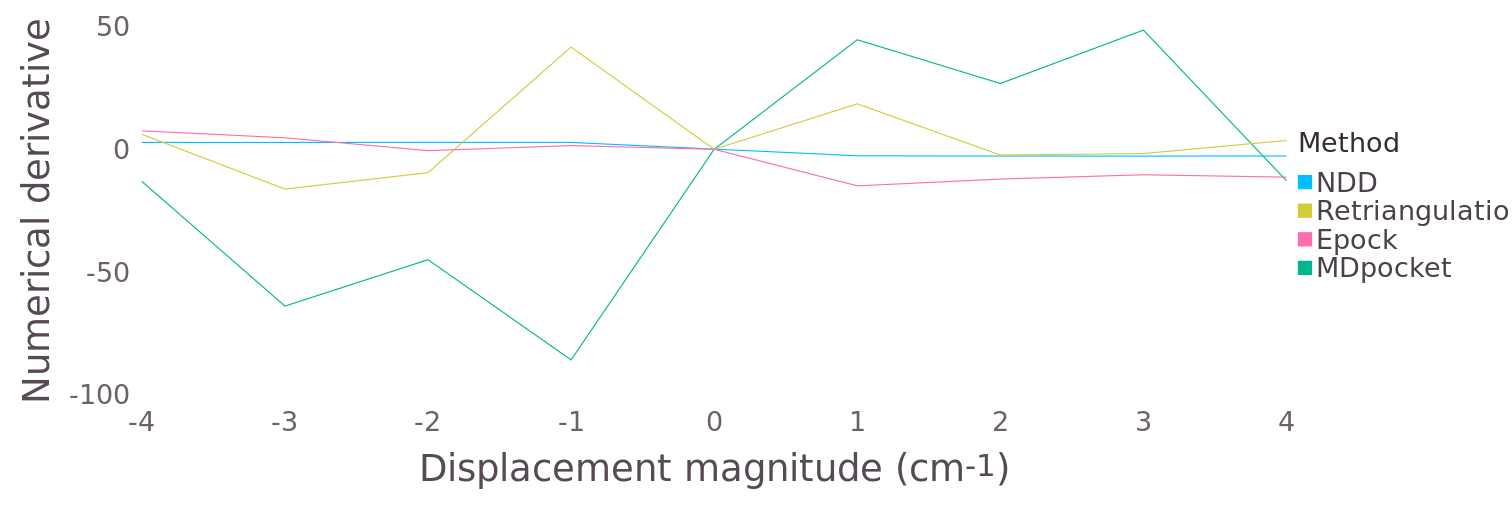

In [118]:
df_gradients = DataFrame(Gradient = [ gdt_ndd[7:15] ; gdt_ana[7:15] ; gdt_epock[7:15] ; gdt_mdpoc[7:15] ],
    Displacement = repeat([ collect(-4:1:-1) ; 0 ; collect(1:4) ], outer = [4]),
    Method = repeat([ "NDD" ; "Retriangulation" ; "Epock" ; "MDpocket" ], inner = [9]))

plot_fig = plot(df_gradients, Geom.line, x = "Displacement", y = "Gradient", color = "Method",

Guide.xlabel("Displacement magnitude (cm<sup>-1</sup>)"), 
Guide.xticks(ticks = [ collect(-4:1:-1) ; 0 ; collect(1:4) ]),
Guide.ylabel("Numerical derivative", orientation=:vertical),
#Guide.yticks(ticks = collect(0.1:0.1:.3)),
Theme(bar_spacing=2pt, grid_line_width=0pt,
minor_label_font_size = 20pt, major_label_font_size = 28pt, key_title_font_size = 20pt,
        key_label_font_size = 20pt))

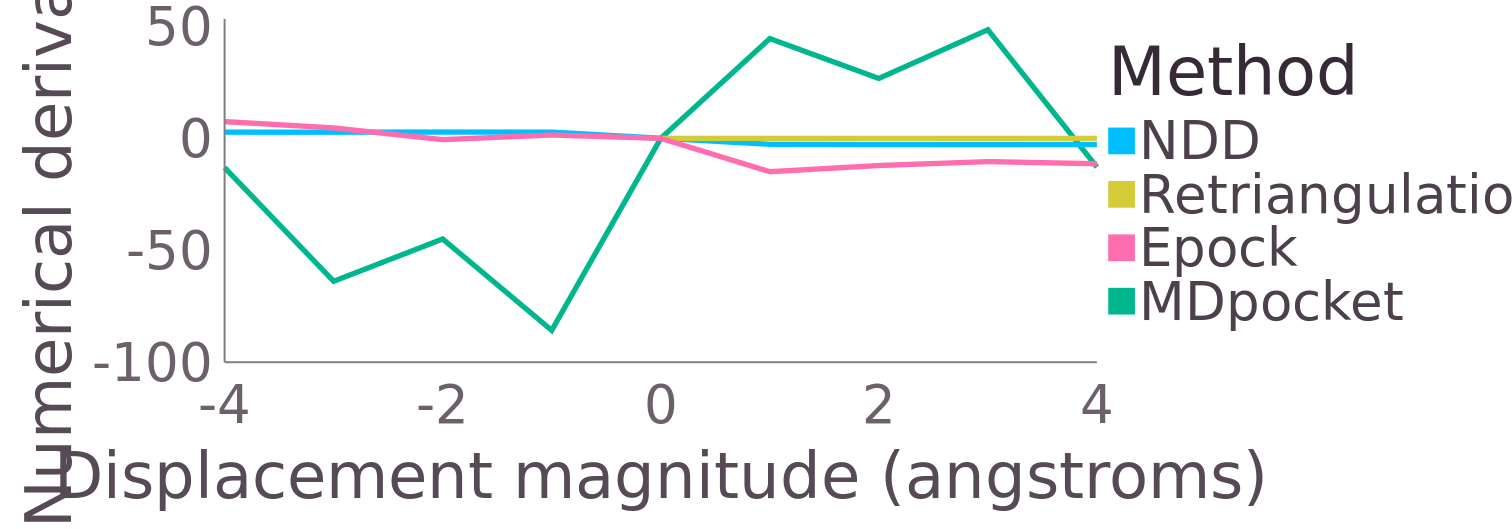

In [124]:
lyr_x_ticks = layer(x =  collect(-4:4), xend = collect(-4:4),
            y = repeat([-101], inner = [9]), yend = repeat([-99], inner = [9]),
            Geom.segment, Theme(default_color=colorant"Black"))
lyr_y_ticks = layer(y =  collect(-100:50:50), yend = collect(-100:50:50),
            x = repeat([-10.1], inner = [4]), xend = repeat([-9.9], inner = [4]),
            Geom.segment, Theme(default_color=colorant"Black"))

df_gdt = DataFrame(Gradient = [ gdte_ndd[7:15] ; gdte_ana[7:15] ; gdte_epock[7:15] ; gdte_mdpoc[7:15] ],
    Displacement = repeat([ collect(-4:1:-1) ; 0 ; collect(1:4) ], outer = [4]),
    Method = repeat([ "NDD" ; "Retriangulation" ; "Epock" ; "MDpocket" ], inner = [9]))

lyr_gdt = layer(df_gdt, Geom.line, x = "Displacement", y = "Gradient", color = "Method")

pdf_gdt = plot(lyr_gdt, #lyr_x_ticks, lyr_y_ticks,

Guide.annotation(compose(context(), line([(-4., -100), (4, -100), ]),
Compose.stroke("gray"), Compose.fill("gray") )),
Guide.annotation(compose(context(), line([(-4., -100), (-4., 60.), ]),
Compose.stroke("gray"), Compose.fill("gray") )),    
    
Guide.xlabel("Displacement magnitude (angstroms)"), 
Guide.ylabel("Numerical derivative", orientation=:vertical),
#Guide.xticks(ticks = [ collect(-10:1:-1) ; 0 ; collect(1:10) ]),
#Guide.yticks(ticks = collect(0.1:0.1:.3)),
Theme(bar_spacing=2pt, grid_line_width=0pt, default_color=colorant"LightSalmon",
    minor_label_font_size = 40pt, major_label_font_size = 48pt, key_title_font_size = 50pt,
    key_label_font_size = 40pt, line_width = 4pt))

In [ ]:
df_vol = DataFrame(Gradient = [ vol_ndd[7:15] ; vol_ana[7:15] ; vol_epock[7:15] ; vol_mdpoc[7:15] ],
    Displacement = repeat([ collect(-4:1:-1) ; 0 ; collect(1:4) ], outer = [4]),
    Method = repeat([ "NDD" ; "Retriangulation" ; "Epock" ; "MDpocket" ], inner = [9]))

plot_fig = plot(df_vol, Geom.line, x = "Displacement", y = "Gradient", color = "Method",

Guide.xlabel("Displacement magnitude (cm<sup>-1</sup>)"), 
Guide.xticks(ticks = [ collect(-4:1:-1) ; 0 ; collect(1:4) ]),
Guide.ylabel("Numerical derivative", orientation=:vertical),
#Guide.yticks(ticks = collect(0.1:0.1:.3)),
Theme(bar_spacing=2pt, grid_line_width=0pt,
minor_label_font_size = 20pt, major_label_font_size = 28pt, key_title_font_size = 20pt,
        key_label_font_size = 20pt))

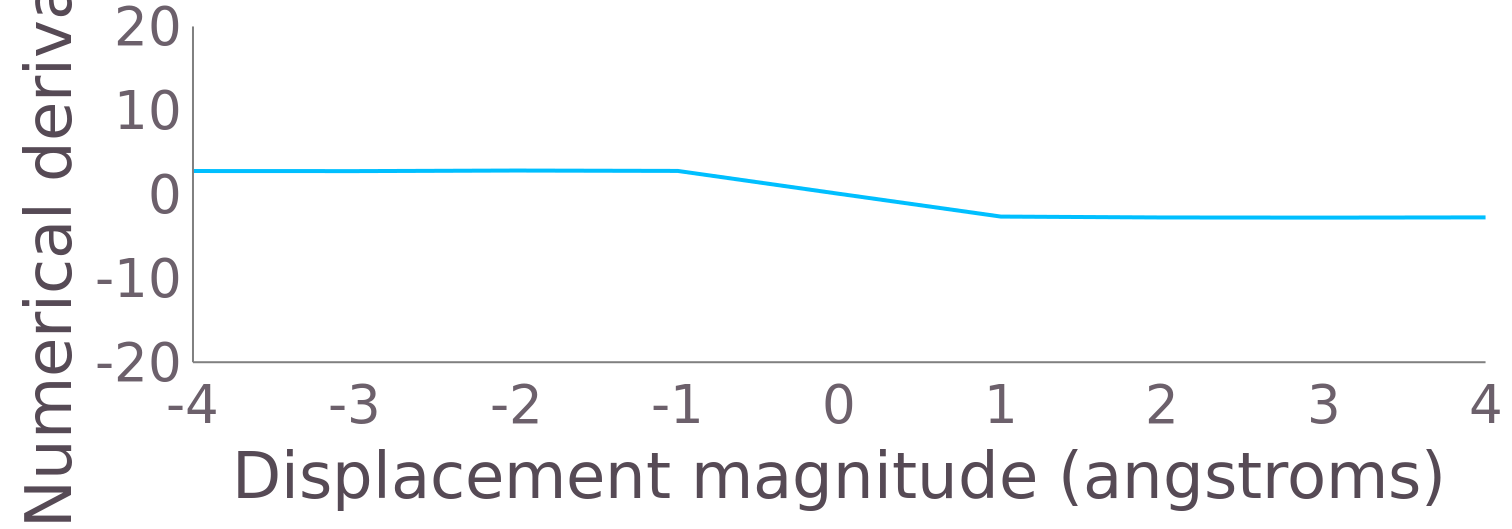

In [145]:
df_gdt_ndd = DataFrame(Gradient = gdt_ndd[7:15] ,
    Displacement = repeat([ collect(-4:1:-1) ; 0 ; collect(1:4) ], outer = [1]),
    Method = repeat([ "NDD" ], inner = [9]))

pdf_gdt_ndd = plot(df_gdt_ndd, Geom.line, x = "Displacement", y = "Gradient", 
    
Guide.annotation(compose(context(), line([(-4., -20), (4, -20), ]),
Compose.stroke("gray"), Compose.fill("gray") )),
Guide.annotation(compose(context(), line([(-4., -20), (-4., 20.), ]),
Compose.stroke("gray"), Compose.fill("gray") )),

Guide.xlabel("Displacement magnitude (angstroms)"), 
Guide.xticks(ticks = [ collect(-4:1:-1) ; 0 ; collect(1:4) ]),
Guide.ylabel("Numerical derivative", orientation=:vertical),
#Guide.yticks(ticks = collect(1300:50:1400)),
    
Coord.cartesian(ymin = -20, ymax = 20),
Theme(bar_spacing=2pt, grid_line_width=0pt,
    minor_label_font_size = 40pt, major_label_font_size = 48pt, key_title_font_size = 20pt, line_width = 3pt))

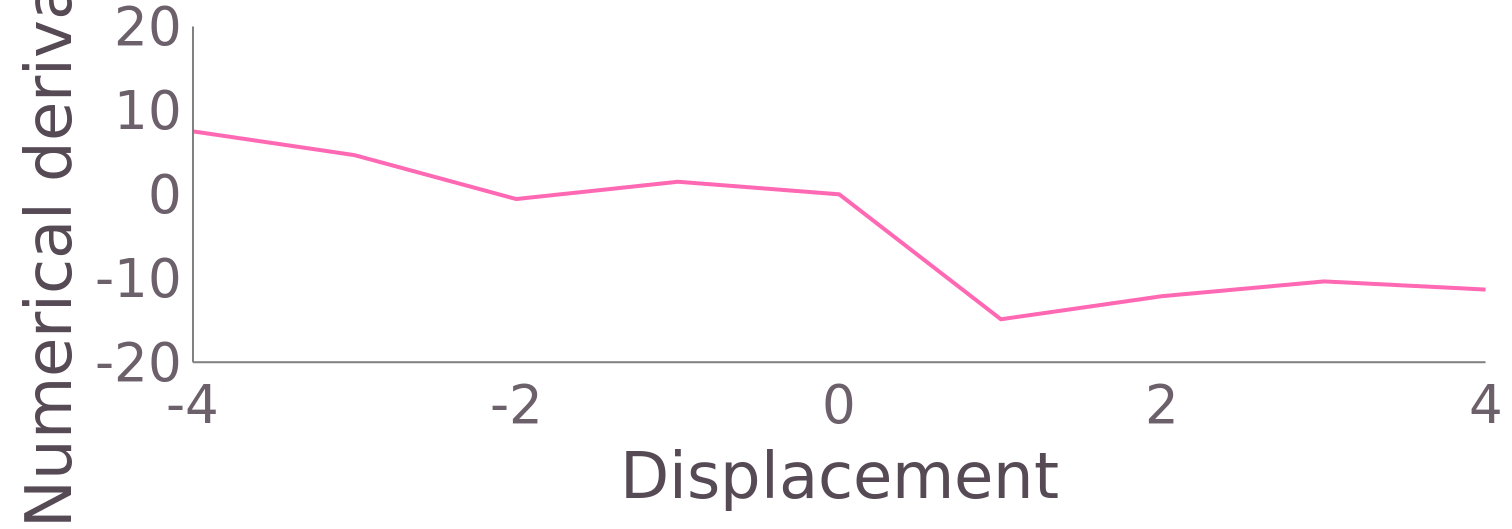

In [146]:
df_gdte_epock = DataFrame(Gradient = gdt_epock[7:15] ,
    Displacement = repeat([ collect(-4:1:-1) ; 0 ; collect(1:4) ], outer = [1]),
    Method = repeat([ "POVME" ], inner = [9]))

pdf_gdt_epock = plot(df_gdte_epock, Geom.line, x = "Displacement", y = "Gradient", 

Guide.annotation(compose(context(), line([(-4., -20), (4, -20), ]),
Compose.stroke("gray"), Compose.fill("gray") )),
Guide.annotation(compose(context(), line([(-4., -20), (-4., 20.), ]),
Compose.stroke("gray"), Compose.fill("gray") )),

Guide.ylabel("Numerical derivative", orientation=:vertical),
Coord.cartesian(ymin = -20, ymax = 20),
Theme(bar_spacing=2pt, grid_line_width=0pt, default_color=colorant"Hotpink",
    minor_label_font_size = 40pt, major_label_font_size = 48pt, key_title_font_size = 20pt, line_width = 3pt))

In [147]:
fig_out_filename = string("/home/german/labo/16/rtas_a_reviewers/ndd_check/gdt_linealidad.png")
draw(PNG(fig_out_filename, 60cm, 40cm), pdf_gdt)

In [148]:
fig_out_filename = string("/home/german/labo/16/rtas_a_reviewers/ndd_check/gdt_ndd.png")
draw(PNG(fig_out_filename, 60cm, 40cm), pdf_gdt_ndd)

In [149]:
fig_out_filename = string("/home/german/labo/16/rtas_a_reviewers/ndd_check/gdt_epock.png")
draw(PNG(fig_out_filename, 60cm, 40cm), pdf_gdt_epock)